## Load the dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from PIL import Image
import os

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jessicali9530/celeba-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sayandafadar
Your Kaggle Key: ··········


100%|██████████| 1.33G/1.33G [00:59<00:00, 23.9MB/s]


In [2]:
# Load an image as an rgb array
def load_image(filename):
  image = Image.open(filename)
  image = image.convert('RGB')
  pixels = np.asarray(image)
  image = Image.fromarray(pixels)
  image = image.resize((80, 80))
  face_array = np.asarray(image)
  return face_array

In [3]:
def plot_faces(faces, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(faces[i])
  plt.show()

In [ ]:
def load_faces(directory, n_faces):
  faces = list()
  for filename in os.listdir(directory):
    face = load_image(directory + filename)
    faces.append(face)
    if len(faces) >= n_faces:
      break
  return np.asarray(faces)

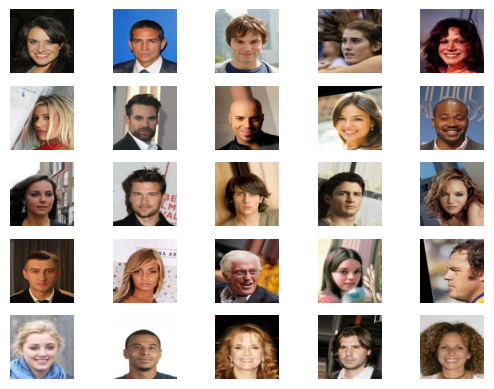

In [ ]:
directory = '/content/celeba-dataset/img_align_celeba/img_align_celeba/'

faces = load_faces(directory, 25)
plot_faces(faces, 5)

In [ ]:
directory = '/content/celeba-dataset/img_align_celeba/img_align_celeba/'
all_faces = load_faces(directory, 40000)
print('Loaded: ', all_faces.shape)
np.savez_compressed('img_align_celeba.npz', all_faces)

Loaded:  (40000, 80, 80, 3)


## Discriminator

In [ ]:
def define_discriminator(in_shape=(80, 80, 3)):
  model = keras.Sequential()
  model.add(layers.Conv2D(128, (5, 5), padding="same", input_shape=in_shape))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                metrics=["accuracy"])
  return model

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 80, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 40, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       409728    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 20, 20, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       4

## Generator

In [ ]:
def define_generator(latent_dim):
  model = keras.Sequential()
  n_nodes = 128 * 5 * 5
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Reshape((5, 5, 128)))
  # Upsample to 10x10
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  # Upsample to 20x20
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  # Upsample to 40x40
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  # Upsample to 80x80
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  # Ouput layer 80x80x3
  model.add(layers.Conv2D(3, (5, 5), activation="tanh", padding="same"))
  return model

In [ ]:
generator = define_generator(100)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3200)              323200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 3200)              0         
                                                                 
 reshape (Reshape)           (None, 5, 5, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 10, 10, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 20, 20, 128)      262272    
 ranspose)                                            

## GAN (An adversarial network between the Generator and the Discriminator)

In [ ]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = keras.Sequential()
  model.add(g_model)
  model.add(d_model)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
  return model

In [ ]:
# Preprocess the data
def load_real_samples():
  data = np.load('img_align_celeba.npz')
  x = data['arr_0']
  x = x.astype('float32')
  x = (x - 127.5) / 127.5
  return x

In [ ]:
# Generate real samples
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  x = dataset[ix]
  y = np.ones((n_samples, 1))
  return x, y

In [ ]:
# Generate points in the latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  # Reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
# Generate fake examples
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  x = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return x, y

In [ ]:
# Create and save a plot of generated images
def save_plot(examples, epoch, n=10):
  # Scale form [-1, 1] to [0, 1]
  examples = (examples + 1) / 2.0
  # Plot image
  for i in range(n * n):
    plt.subplot(n, n, i + 1)
    plt.axis("off")
    plt.imshow(examples[i])
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [ ]:
# Evaluate the GAN
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  x_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)) # save plot
  save_plot(x_fake, epoch) 
  # save the generator model tile file 
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [ ]:
# Train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % 
       (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if (i+1) % 10 == 0: 
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 16ms/step
>2, 310/312, d1=0.037, d2=0.060 g=4.036
2/2 [==============================] - 0s 17ms/step
>2, 311/312, d1=0.112, d2=0.080 g=4.147
2/2 [==============================] - 0s 17ms/step
>2, 312/312, d1=0.038, d2=0.031 g=4.393
2/2 [==============================] - 0s 17ms/step
>3, 1/312, d1=0.239, d2=0.078 g=3.785
2/2 [==============================] - 0s 17ms/step
>3, 2/312, d1=0.103, d2=0.103 g=4.410
2/2 [==============================] - 0s 17ms/step
>3, 3/312, d1=0.319, d2=0.073 g=3.606
2/2 [==============================] - 0s 17ms/step
>3, 4/312, d1=0.173, d2=0.110 g=3.883
2/2 [==============================] - 0s 17ms/step
>3, 5/312, d1=0.109, d2=0.045 g=4.304
2/2 [==============================] - 0s 17ms/step
>3, 6/312, d1=0.108, d2=0.059 g=4.160
2/2 [==============================] - 0s 17ms/step
>3, 7/312, d1=0.187, d2=0.238 g=4.366
2/2 [==============================] - 0s 1

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 17ms/step
>12, 310/312, d1=0.229, d2=0.322 g=3.076
2/2 [==============================] - 0s 17ms/step
>12, 311/312, d1=0.444, d2=0.268 g=2.566
2/2 [==============================] - 0s 17ms/step
>12, 312/312, d1=0.331, d2=0.427 g=2.799
2/2 [==============================] - 0s 18ms/step
>13, 1/312, d1=0.248, d2=0.240 g=3.072
2/2 [==============================] - 0s 17ms/step
>13, 2/312, d1=0.522, d2=0.374 g=2.867
2/2 [==============================] - 0s 17ms/step
>13, 3/312, d1=0.333, d2=0.341 g=2.806
2/2 [==============================] - 0s 17ms/step
>13, 4/312, d1=0.560, d2=0.244 g=2.451
2/2 [==============================] - 0s 17ms/step
>13, 5/312, d1=0.252, d2=0.464 g=2.881
2/2 [==============================] - 0s 17ms/step
>13, 6/312, d1=0.373, d2=0.178 g=2.775
2/2 [==============================] - 0s 17ms/step
>13, 7/312, d1=0.449, d2=0.360 g=2.362
2/2 [============================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 17ms/step
>22, 310/312, d1=0.706, d2=0.430 g=2.193
2/2 [==============================] - 0s 17ms/step
>22, 311/312, d1=0.369, d2=0.400 g=2.281
2/2 [==============================] - 0s 17ms/step
>22, 312/312, d1=0.430, d2=0.430 g=2.614
2/2 [==============================] - 0s 18ms/step
>23, 1/312, d1=0.427, d2=0.285 g=2.465
2/2 [==============================] - 0s 18ms/step
>23, 2/312, d1=0.483, d2=0.427 g=2.382
2/2 [==============================] - 0s 17ms/step
>23, 3/312, d1=0.422, d2=0.335 g=2.274
2/2 [==============================] - 0s 20ms/step
>23, 4/312, d1=0.324, d2=0.355 g=2.494
2/2 [==============================] - 0s 16ms/step
>23, 5/312, d1=0.595, d2=0.357 g=2.292
2/2 [==============================] - 0s 17ms/step
>23, 6/312, d1=0.281, d2=0.408 g=2.506
2/2 [==============================] - 0s 16ms/step
>23, 7/312, d1=0.440, d2=0.319 g=2.284
2/2 [============================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 17ms/step
>32, 310/312, d1=0.491, d2=0.462 g=2.320
2/2 [==============================] - 0s 17ms/step
>32, 311/312, d1=0.440, d2=0.293 g=2.282
2/2 [==============================] - 0s 17ms/step
>32, 312/312, d1=0.418, d2=0.364 g=2.278
2/2 [==============================] - 0s 20ms/step
>33, 1/312, d1=0.367, d2=0.403 g=2.623
2/2 [==============================] - 0s 16ms/step
>33, 2/312, d1=0.602, d2=0.458 g=2.423
2/2 [==============================] - 0s 19ms/step
>33, 3/312, d1=0.437, d2=0.348 g=2.346
2/2 [==============================] - 0s 17ms/step
>33, 4/312, d1=0.359, d2=0.353 g=2.416
2/2 [==============================] - 0s 16ms/step
>33, 5/312, d1=0.500, d2=0.395 g=2.229
2/2 [==============================] - 0s 18ms/step
>33, 6/312, d1=0.386, d2=0.426 g=2.338
2/2 [==============================] - 0s 17ms/step
>33, 7/312, d1=0.426, d2=0.382 g=2.262
2/2 [============================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 18ms/step
>42, 310/312, d1=0.336, d2=0.360 g=2.226
2/2 [==============================] - 0s 17ms/step
>42, 311/312, d1=0.535, d2=0.427 g=2.074
2/2 [==============================] - 0s 23ms/step
>42, 312/312, d1=0.495, d2=0.402 g=2.041
2/2 [==============================] - 0s 18ms/step
>43, 1/312, d1=0.454, d2=0.589 g=2.186
2/2 [==============================] - 0s 17ms/step
>43, 2/312, d1=0.431, d2=0.367 g=2.382
2/2 [==============================] - 0s 17ms/step
>43, 3/312, d1=0.412, d2=0.305 g=2.222
2/2 [==============================] - 0s 18ms/step
>43, 4/312, d1=0.526, d2=0.325 g=2.029
2/2 [==============================] - 0s 17ms/step
>43, 5/312, d1=0.391, d2=0.537 g=1.952
2/2 [==============================] - 0s 17ms/step
>43, 6/312, d1=0.405, d2=0.385 g=2.048
2/2 [==============================] - 0s 17ms/step
>43, 7/312, d1=0.395, d2=0.340 g=2.036
2/2 [============================

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 17ms/step
>52, 212/312, d1=0.958, d2=0.533 g=3.714
2/2 [==============================] - 0s 18ms/step
>52, 213/312, d1=0.802, d2=0.961 g=3.799
2/2 [==============================] - 0s 18ms/step
>52, 214/312, d1=0.920, d2=0.995 g=3.182
2/2 [==============================] - 0s 17ms/step
>52, 215/312, d1=1.650, d2=1.785 g=3.487
2/2 [==============================] - 0s 20ms/step
>52, 216/312, d1=1.236, d2=0.264 g=2.679
2/2 [==============================] - 0s 19ms/step
>52, 217/312, d1=0.708, d2=1.003 g=2.249
2/2 [==============================] - 0s 17ms/step
>52, 218/312, d1=0.674, d2=0.791 g=1.993
2/2 [==============================] - 0s 20ms/step
>52, 219/312, d1=1.034, d2=1.184 g=1.656
2/2 [==============================] - 0s 17ms/step
>52, 220/312, d1=1.136, d2=0.564 g=1.726
2/2 [==============================] - 0s 17ms/step
>52, 221/312, d1=0.939, d2=1.011 g=1.603
2/2 [==============

## Explore the Latent Space for Generated Faces

1/1 [==============================] - 9s 9s/step


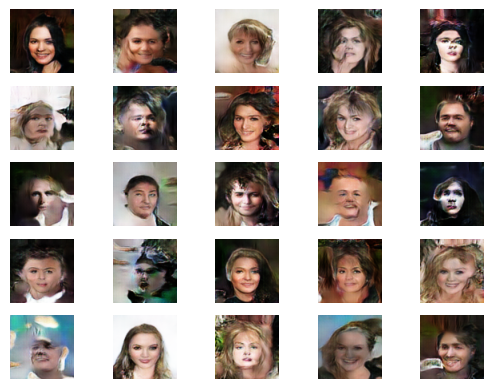

In [5]:
def generate_latent_points(latent_dim, n_samples):
  # Generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # Reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input

def plot_generated(examples, n):
  for i in range(n*n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :])
  plt.show()

model = keras.models.load_model('/content/generator_model_030.h5')
latent_points = generate_latent_points(100, 25)
x = model.predict(latent_points)
x = (x + 1) / 2.0
plot_generated(x, 5)

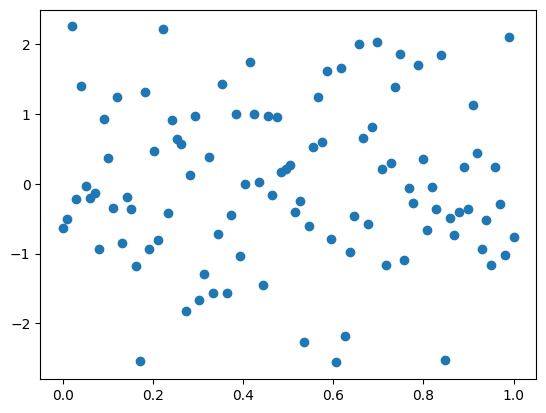

In [59]:
plt.scatter(np.linspace(0, 1, 100), latent_points);

1/1 [==============================] - 0s 18ms/step


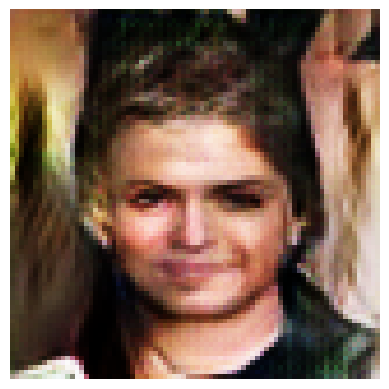

In [27]:
latent_points = generate_latent_points(100, 1)
x = model.predict(latent_points)
x = (x + 1) / 2.0
plt.imshow(x[0, :, :])
plt.axis("off");

### Uniform interpolation between two points in latent space

In [40]:
def interpolate_points(p1, p2, n_steps=10):
  ratios = np.linspace(0, 1, num=n_steps)
  vectors = list()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  return np.asarray(vectors)

def plot_generated(examples, n):
  for i in range(n):
    plt.subplot(1, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :])
  plt.show()

1/1 [==============================] - 0s 30ms/step


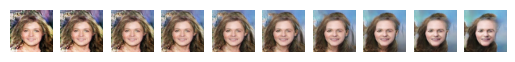

In [54]:
pts = generate_latent_points(100, 2)
interpolated = interpolate_points(pts[0], pts[1])
x = model.predict(interpolated)
x = (x + 1) / 2.0
plot_generated(x, len(interpolated))

1/1 [==============================] - 0s 27ms/step


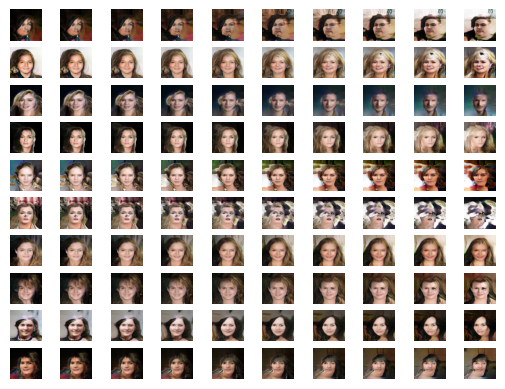

In [55]:
def plot_generated(examples, n):
  for i in range(n*n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :])
  plt.show()

n = 20
pts = generate_latent_points(100, n)
results = None
for i in range(0, n, 2):
  interpolated = interpolate_points(pts[i], pts[i+1])
  x = model.predict(interpolated)
  x = (x + 1) / 2.0
  if results is None:
    results = x
  else:
    results = np.vstack((results, x))
plot_generated(results, 10)

In [56]:
def slerp(val, low, high):
  omega = np.arccos(np.clip(np.dit(low/np.norm(low), high/np.norm(high)), -1, 1))
  so = np.sin(omega)
  if so == 0:
    return (1.0-val) * low + val * high
  return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

In [57]:
def interpolated_points(p1, p2, n_steps=10):
  ratios = np.linspace(0, 1, num=n_steps)
  vectors = list()
  for ratio in ratios:
    v = slerp(ratio, p1, p2)
    vectors.append(v)
  return np.asarray(vectors)

1/1 [==============================] - 0s 17ms/step


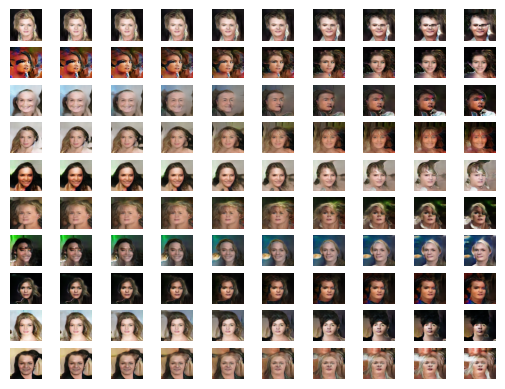

In [58]:
n = 20
pts = generate_latent_points(100, n)
results = None
for i in range(0, n, 2):
  interpolated = interpolate_points(pts[i], pts[i+1])
  x = model.predict(interpolated)
  x = (x + 1) / 2.0
  if results is None:
    results = x
  else:
    results = np.vstack((results, x))
plot_generated(results, 10)

In [60]:
def plot_generated(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :])
  plt.savefig('generated_faces.png')
  plt.close()

latent_points = generate_latent_points(100, 100)
np.savez_compressed('latent_points.npz', latent_points)
x = model.predict(latent_points)
x = (x + 1) / 2.0
plot_generated(x, 10)

4/4 [==============================] - 1s 91ms/step
